# Differential Abundance

In [101]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import seaborn as sns
from scipy.stats import shapiro, kruskal, f_oneway
import numpy as np
    
%matplotlib inline

In [102]:
data_dir = 'data/'
data_dir_diff = 'data/differential_abundance/'

In [103]:
data = q2.Artifact.load(f'{data_dir}/closed_reference_cluster/cr90_feature_table.qza').view(pd.DataFrame)

In [18]:
top_three = data[data.sum()[:3].index]
top_three.columns

Index(['SH1135439.10FU_DQ641243_reps', 'SH1135454.10FU_DQ641241_reps',
       'SH1305966.10FU_MK128991_reps'],
      dtype='object')

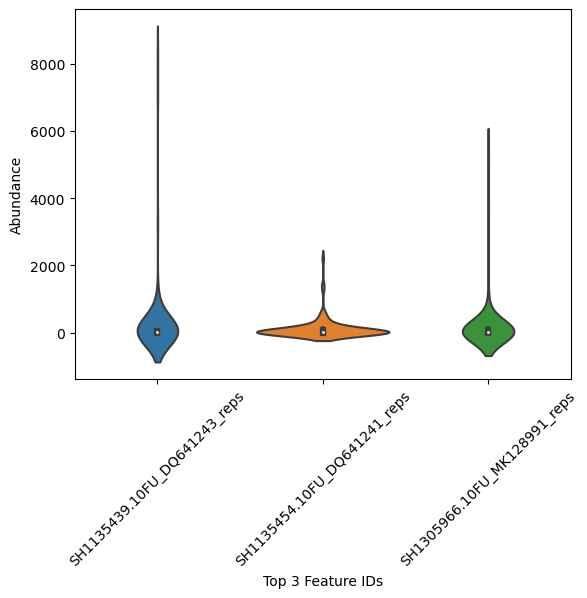

In [19]:
sns.violinplot(data = top_three)
plt.xlabel("Top 3 Feature IDs")
plt.ylabel("Abundance")
plt.xticks(rotation = 45)
plt.show()

In [43]:
n = 10

# draw n ASVs out of the original DataFrame
data_samp = data.sample(n = n, axis = 1, random_state = 234)

# create a new DataFrame with three columns (sample, ASV, abundance)
col_names = {'level_0': 'sample', 'level_1': 'asv', 0: 'count'}
data_plot = data_samp.stack().reset_index().rename(columns=col_names)

# make sure the shape is correct (no. of rows should be equal to the size of our random 
# sample multiplied by number of samples)
assert data_plot.shape[0] == n * data_samp.shape[0], 'The new DataFrame has an incorrect no. of rows.'

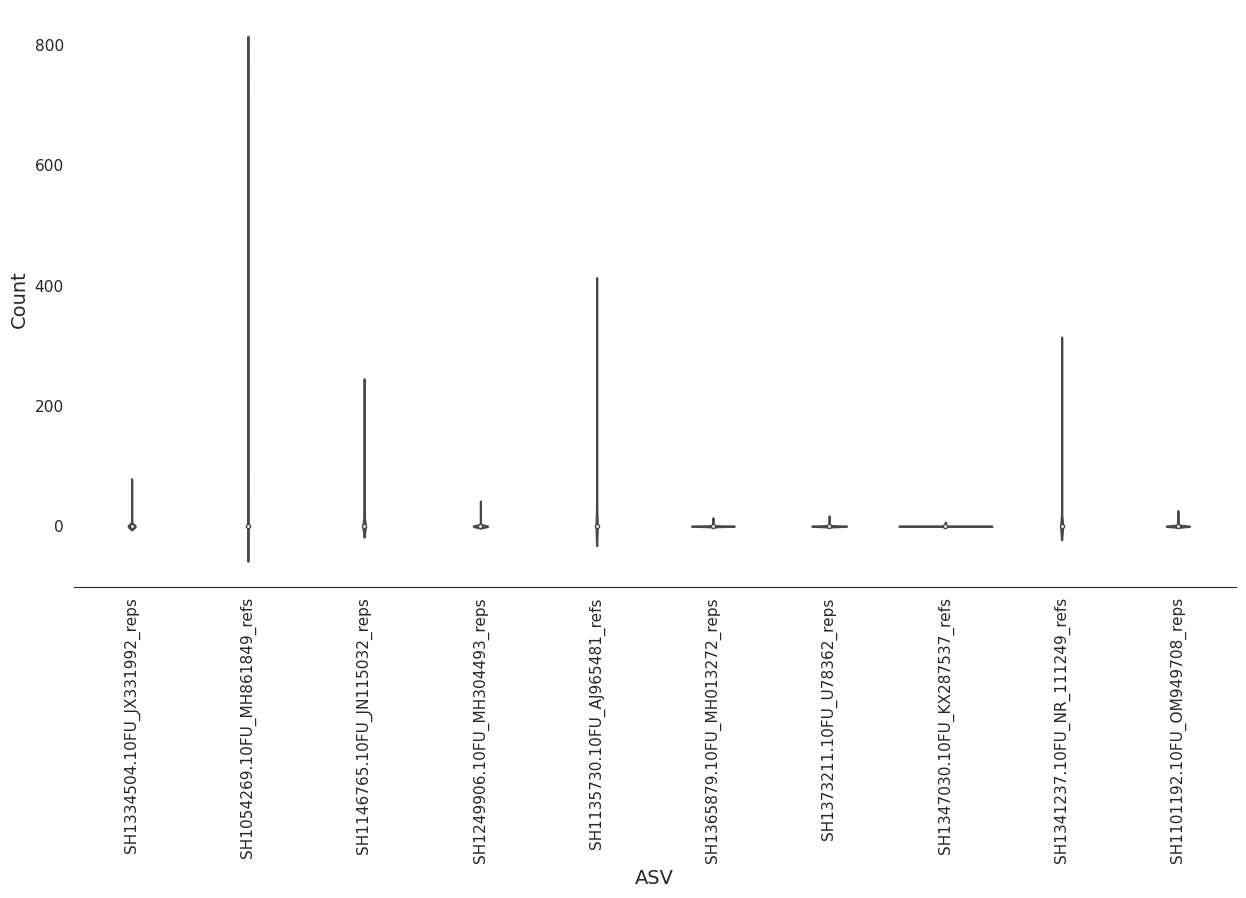

In [44]:
with sns.axes_style('white'), sns.color_palette('Set1'):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 7.5)
    
    sns.violinplot(data=data_plot, x='asv', y='count', ax=ax)
    sns.despine(left=True)
    
    # adjust tick labels and axes titles
    ax.tick_params(axis='x', rotation=90, labelsize=11)
    ax.tick_params(axis='y', labelsize=11)
    ax.set_xlabel('ASV', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)

## Test for Data Normality (Shapiro-Wilk Test)

In [45]:
alpha = 0.05
results = {}

# iterate through rows (samples) and test each of them for normality
for asv_name, asv_values in data.items():
    stat, p = shapiro(asv_values)
    results[asv_name] = p

# convert test results into a DataFrame
results_df = pd.DataFrame(data=results.values(), index=results.keys(), columns=['p'])

# add a new column with a descriptive test result
results_df['is_normal'] = results_df['p'] > alpha

In [49]:
results_df.head()

,p,is_normal
SH1135439.10FU_DQ641243_reps,6.725230e-21,False
SH1135454.10FU_DQ641241_reps,1.246864e-18,False
SH1305966.10FU_MK128991_reps,2.795247e-20,False
SH1223455.10FU_OL895300_reps,6.533499e-20,False
SH1094795.10FU_FR865733_reps,2.612259e-22,False


In [48]:
print('Number of ASVs with normal distribution:', results_df['is_normal'].sum())

Number of ASVs with normal distribution: 0


As expected the data are sparse and not normally distributed.

## ANCOM

In [124]:
np.sum(data, axis = 0).sort_values(ascending = False)

SH1382505.10FU_EF567995_refs       849270.0
SH1338507.10FU_MT974688_reps       813334.0
SH1085902.10FU_AB018043_refs       616525.0
SH1392968.10FU_KJ956016_reps       347613.0
SH1089542.10FU_KM209325_reps       270017.0
                                     ...   
SH1229033.10FU_JF978087_reps            3.0
SH1245415.10FU_UDB07249027_reps         2.0
SH1054565.10FU_MK776933_reps            2.0
SH1108338.10FU_JX233500_reps            2.0
SH1357459.10FU_AB498940_refs            2.0
Length: 414, dtype: float64

In [125]:
! qiime feature-table filter-features \
    --i-table $data_dir/closed_reference_cluster/cr90_feature_table.qza \
    --p-min-frequency 25 \
    --p-min-samples 6 \
    --o-filtered-table $data_dir_diff/table_abund.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund.qza


### Healed vs Healthy

In [115]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[disease_status]='Healthy' or [disease_status]='Healed'" \
    --o-filtered-table $data_dir_diff/table_abund_healthy_healed.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_healthy_healed.qza


In [116]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_healthy_healed.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula disease_status \
    --o-differentials $data_dir_diff/ancombc_healthy_healed.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_healthy_healed.qza \
    --o-visualization $data_dir_diff/ancombc_healthy_healed_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_healthy_healed.qza \
    --o-visualization $data_dir_diff/ancombc_healthy_healed.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_healthy_healed.qza
Saved Visualization to: data/differential_abundance//ancombc_healthy_healed_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_healthy_healed.qzv


In [117]:
Visualization.load(f"{data_dir_diff}/ancombc_healthy_healed.qzv")

<visualization: Visualization uuid: 3c8f5d7f-a770-4eb4-b03b-5e7a5f212002>

In [118]:
Visualization.load(f"{data_dir_diff}/ancombc_healthy_healed_barplot.qzv")

<visualization: Visualization uuid: 65cd8e20-54b7-4add-b8d7-82c5ca345b3f>

Since the q-value is always 1 it means that all features are not differential abundant across healed and healthy patients. Meaning we could treat them as one group from now on.

### Healthy vs. Puns

In [126]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[disease_status]='Healthy' or [disease_status]='Puns'" \
    --o-filtered-table $data_dir_diff/table_abund_healthy_puns.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_healthy_puns.qza


In [127]:
! qiime feature-table summarize \
    --i-table $data_dir_diff/table_abund_healthy_puns.qza \
    --m-sample-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --o-visualization $data_dir_diff/table_abund_healthy_puns.qzv

Saved Visualization to: data/differential_abundance//table_abund_healthy_puns.qzv


In [128]:
Visualization.load(f"{data_dir_diff}/table_abund_healthy_puns.qzv")

<visualization: Visualization uuid: 4ab5d51f-8425-48cb-8e08-c46b1472745a>

In [132]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_healthy_puns.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula disease_status \
    --p-reference-levels disease_status::Healthy \
    --o-differentials $data_dir_diff/ancombc_healthy_puns.qza

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_healthy_puns.qza


In [ ]:
# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_healthy_puns.qza \
    --o-visualization $data_dir_diff/ancombc_healthy_puns_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_healthy_puns.qza \
    --o-visualization $data_dir_diff/ancombc_healthy_puns.qzv

In [134]:
Visualization.load(f"{data_dir_diff}/ancombc_healthy_puns.qzv")

<visualization: Visualization uuid: b026a485-3d5e-493f-a86e-ca4815b7512d>

In [135]:
Visualization.load(f"{data_dir_diff}/ancombc_healthy_puns_barplot.qzv")

<visualization: Visualization uuid: 69b49872-c07e-4274-a179-483817aca814>

There is no significant difference between healthy and disease. 

### Comparison between Pre- and Post-Treatment

#### FMT Response: Pre- and Post-Treatment

In [136]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[subgroup_response]='FMT_Res'" \
    --o-filtered-table $data_dir_diff/table_abund_FMTres.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_FMTres.qza


In [142]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_FMTres.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula time_point \
    --p-reference-levels time_point::pre-treatment \
    --o-differentials $data_dir_diff/ancombc_t_FMTres.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_t_FMTres.qza \
    --o-visualization $data_dir_diff/ancombc_t_FMTres_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_t_FMTres.qza \
    --o-visualization $data_dir_diff/ancombc_t_FMTres.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_t_FMTres.qza
Saved Visualization to: data/differential_abundance//ancombc_t_FMTres_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_t_FMTres.qzv


In [146]:
Visualization.load(f"{data_dir_diff}/ancombc_t_FMTres.qzv")

<visualization: Visualization uuid: c2071f44-52c1-4a2e-a000-62626ae8ac6f>

In [147]:
Visualization.load(f"{data_dir_diff}/ancombc_t_FMTres_barplot.qzv")

<visualization: Visualization uuid: 0d63ba67-4520-4891-9294-5abea3b6e17a>

#### FMT No Response: Pre- and Post-Treatment

In [141]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[subgroup_response]='FMT_NR'" \
    --o-filtered-table $data_dir_diff/table_abund_FMTnr.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_FMTnr.qza


In [143]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_FMTnr.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula time_point \
    --p-reference-levels time_point::pre-treatment \
    --o-differentials $data_dir_diff/ancombc_t_FMTnr.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_t_FMTnr.qza \
    --o-visualization $data_dir_diff/ancombc_t_FMTnr_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_t_FMTnr.qza \
    --o-visualization $data_dir_diff/ancombc_t_FMTnr.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_t_FMTnr.qza
Saved Visualization to: data/differential_abundance//ancombc_t_FMTnr_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_t_FMTnr.qzv


In [148]:
Visualization.load(f"{data_dir_diff}/ancombc_t_FMTnr.qzv")

<visualization: Visualization uuid: a9f6278e-2740-4008-9224-2e1044a5639e>

In [149]:
Visualization.load(f"{data_dir_diff}/ancombc_t_FMTnr_barplot.qzv")

<visualization: Visualization uuid: f8c864ab-56f5-4555-8286-97247b1b87d8>

#### Placebo No Response: Pre- and Post-Treatment

In [138]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[subgroup_response]='Placebo_NR'" \
    --o-filtered-table $data_dir_diff/table_abund_PlaceboNR.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_PlaceboNR.qza


In [144]:
! qiime composition ancombc \
    --i-table $data_dir_diff/table_abund_PlaceboNR.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-formula time_point \
    --p-reference-levels time_point::pre-treatment \
    --o-differentials $data_dir_diff/ancombc_t_PlaceboNR.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir_diff/ancombc_t_PlaceboNR.qza \
    --o-visualization $data_dir_diff/ancombc_t_PlaceboNR_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir_diff/ancombc_t_PlaceboNR.qza \
    --o-visualization $data_dir_diff/ancombc_t_PlaceboNR.qzv

Saved FeatureData[DifferentialAbundance] to: data/differential_abundance//ancombc_t_PlaceboNR.qza
Saved Visualization to: data/differential_abundance//ancombc_t_PlaceboNR_barplot.qzv
Saved Visualization to: data/differential_abundance//ancombc_t_PlaceboNR.qzv


In [150]:
Visualization.load(f"{data_dir_diff}/ancombc_t_PlaceboNR.qzv")

<visualization: Visualization uuid: f97450ef-2d80-419f-963b-f21d37e543e3>

In [151]:
Visualization.load(f"{data_dir_diff}/ancombc_t_PlaceboNR_barplot.qzv")

<visualization: Visualization uuid: f0e3eb0e-dae9-4674-8bd1-d09059cf1d41>

#### Placebo Response: Pre- and Post-Treatment

In [139]:
! qiime feature-table filter-samples \
    --i-table $data_dir_diff/table_abund.qza \
    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --p-where "[subgroup_response]='Placebo_Res'" \
    --o-filtered-table $data_dir_diff/table_abund_PlaceboRes.qza

Saved FeatureTable[Frequency] to: data/differential_abundance//table_abund_PlaceboRes.qza


In [155]:
! qiime feature-table summarize \
    --i-table $data_dir_diff/table_abund_PlaceboRes.qza \
    --m-sample-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
    --o-visualization $data_dir_diff/table_abund_PlaceboRes.qzv

Saved Visualization to: data/differential_abundance//table_abund_PlaceboRes.qzv


In [156]:
Visualization.load(f"{data_dir_diff}/table_abund_PlaceboRes.qzv")

<visualization: Visualization uuid: 5ba7556c-ebec-4c5d-a546-74f3b2c85a51>

In [158]:
#! qiime composition ancombc \
#    --i-table $data_dir_diff/table_abund_PlaceboRes.qza \
#    --m-metadata-file $data_dir/pundemic_metadata_subgroup_response_all.tsv \
#    --p-formula time_point \
#    --p-reference-levels time_point::pre-treatment \
#    --o-differentials $data_dir_diff/ancombc_t_PlaceboRes.qza

# Generate a barplot of differentially abundant taxa between environments
#! qiime composition da-barplot \
#    --i-data $data_dir_diff/ancombc_t_PlaceboRes.qza \
#    --o-visualization $data_dir_diff/ancombc_t_PlaceboRes_barplot.qzv

# Generate a table of these same values for all taxa
#! qiime composition tabulate \
#    --i-data $data_dir_diff/ancombc_t_PlaceboRes.qza \
#    --o-visualization $data_dir_diff/ancombc_t_PlaceboRes.qzv

#! cat /tmp/qiime2-q2cli-err-qx1c_8iq.log

#Error: No residual degrees of freedom! The model is over-parameterized; Please consider a more parsimonious model

Since Placebo- Response is over-parameterized with only 2 samples, we cannot run the differential abundance analysis